In [4]:
import pandas as pd
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from random import random
from io_utils import *

In [5]:
from LightCurve import LightCurve

In [6]:
data_ob = load_RESSPECT_data()
object_ids = data_ob.get_all_object_ids()

In [7]:
data_ob.df_metadata

SNID,redshift,type,code,sample
float64,float64,str10,float64,str5
6612.0,0.41613463,II_V19,42.0,train
7860.0,0.23487686,II-NMF,42.0,train
3421.0,0.14118282,II-NMF,42.0,train
3368.0,0.26212534,II-NMF,42.0,train
3200.0,0.47726378,II_V19,42.0,train
2478.0,0.5132554,II_V19,42.0,train
1640.0,0.20038009,IIn,42.0,train
6509.0,0.2553885,II_V19,42.0,train
2002.0,0.2602583,II_V19,42.0,train


In [8]:
color_band_dict = {'u':'C4','g':'C2', 'r':'C3', 'i':'C1', 'z':'k', 'Y':'C5'}

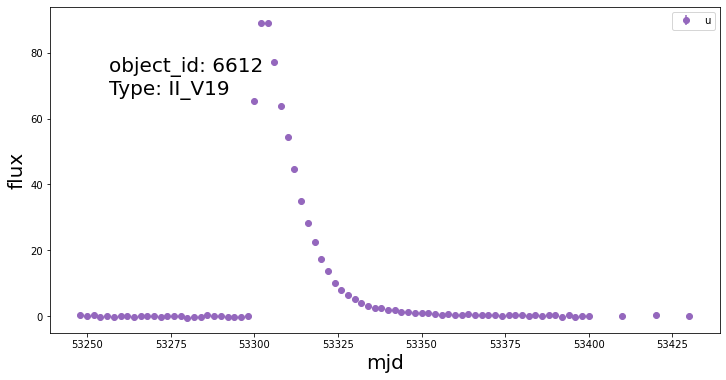

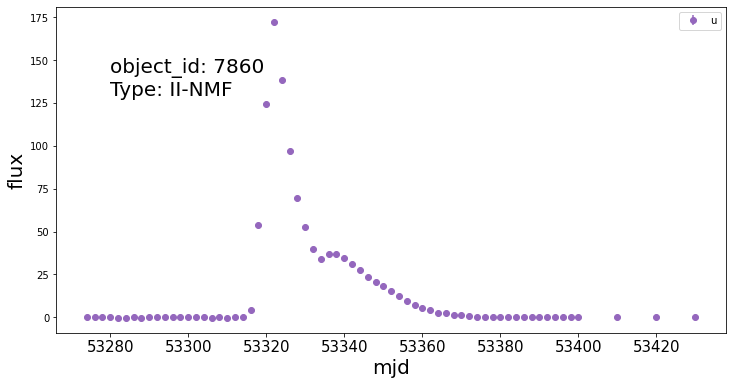

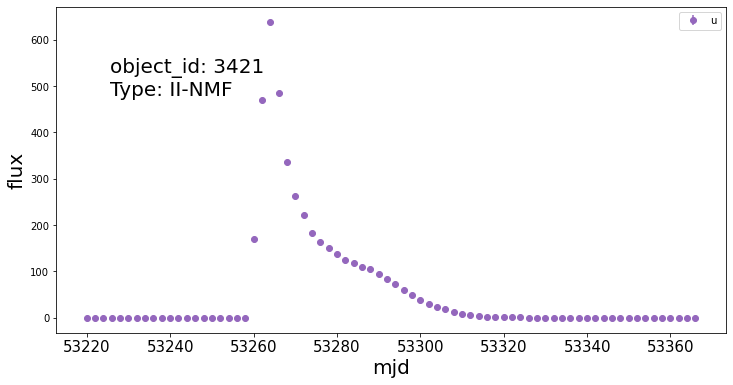

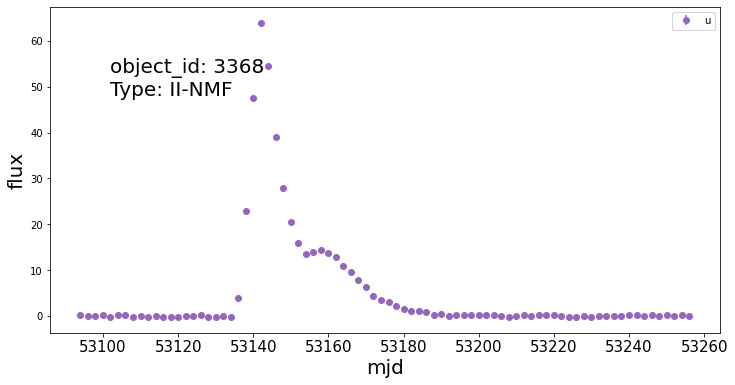

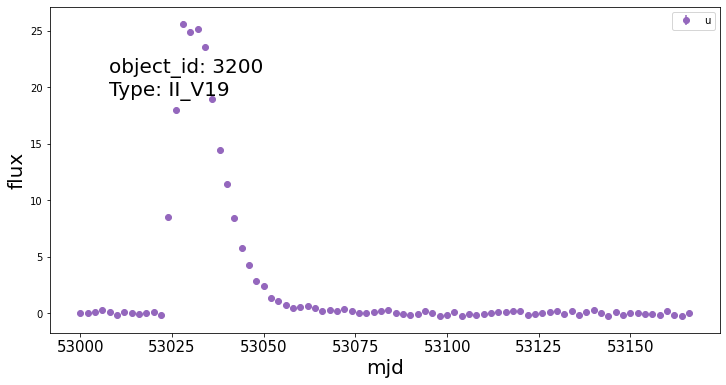

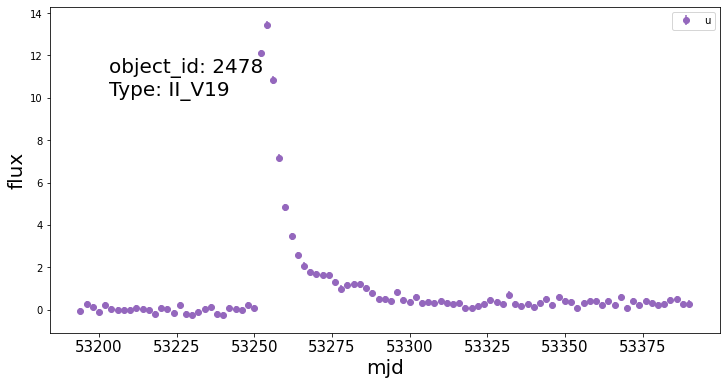

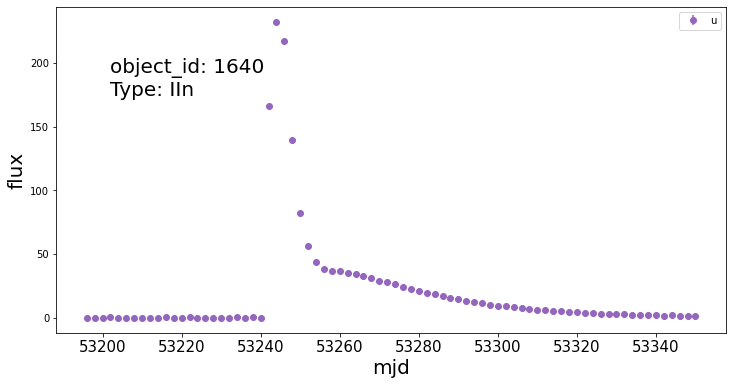

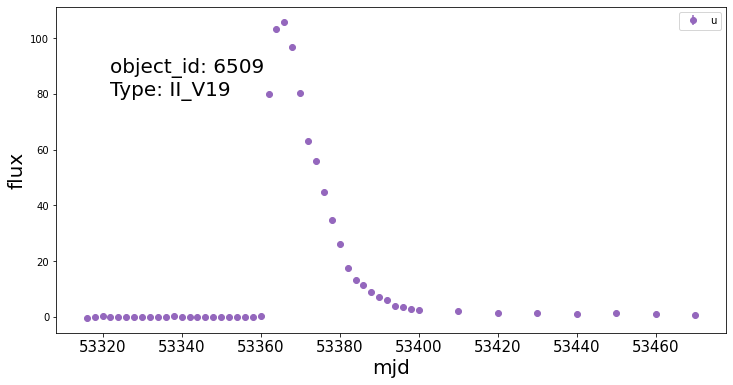

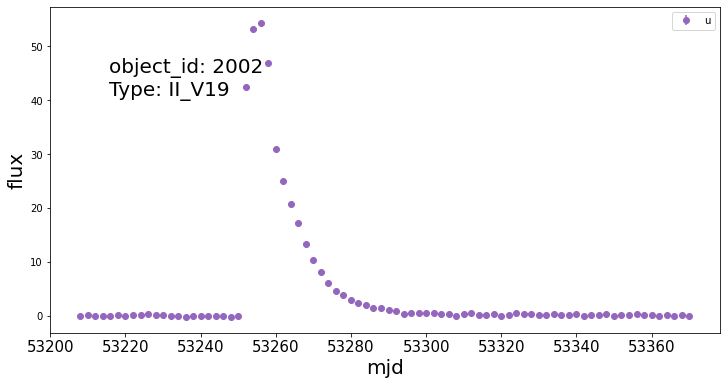

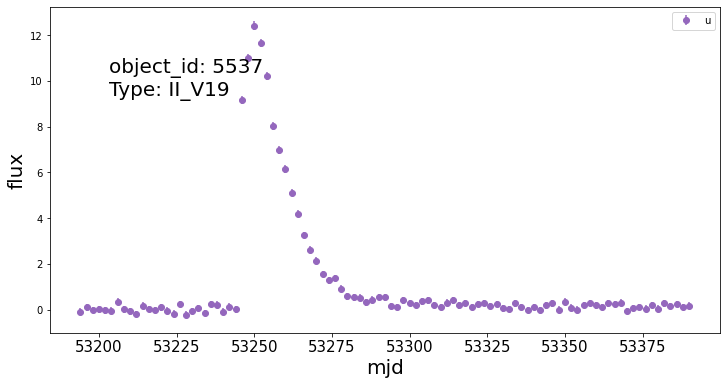

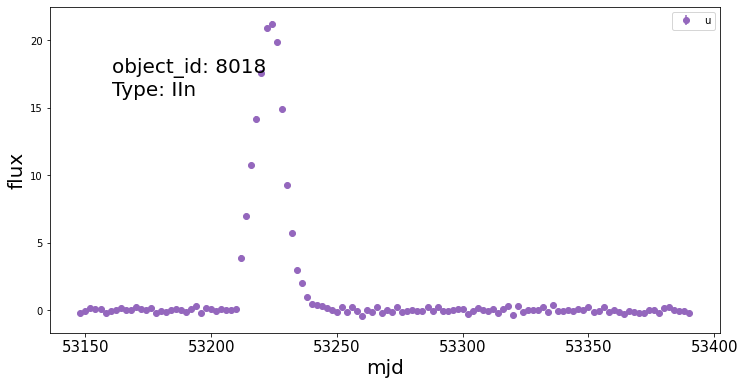

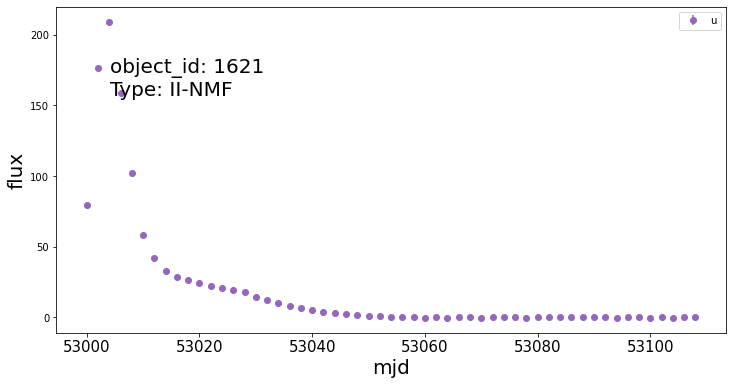

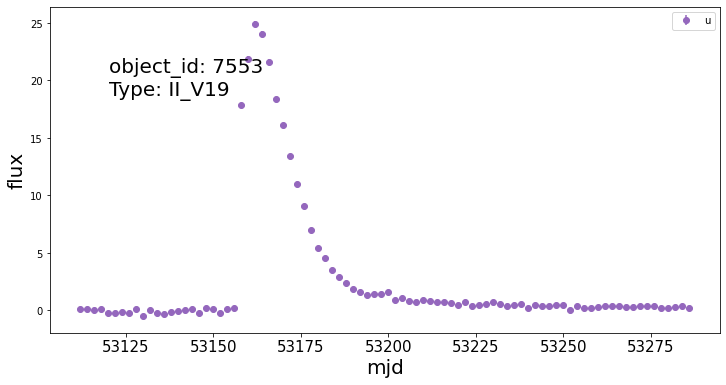

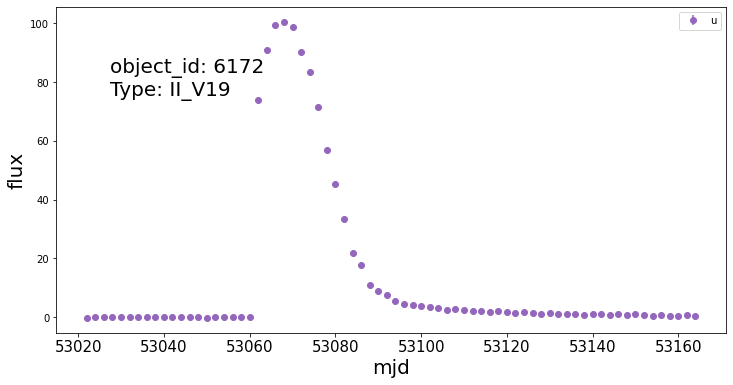

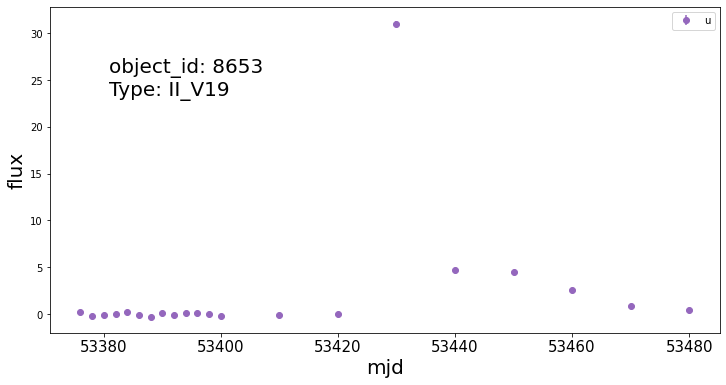

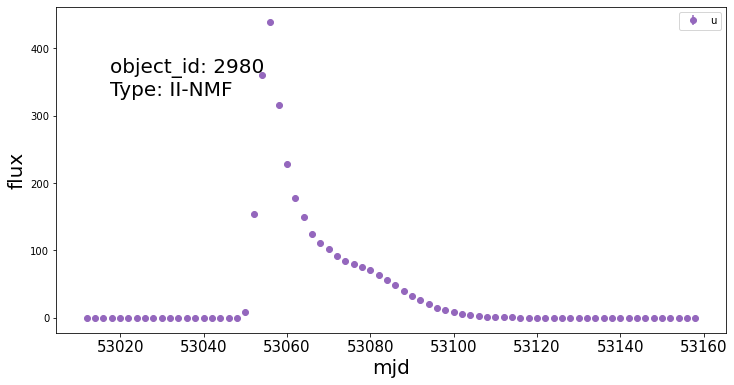

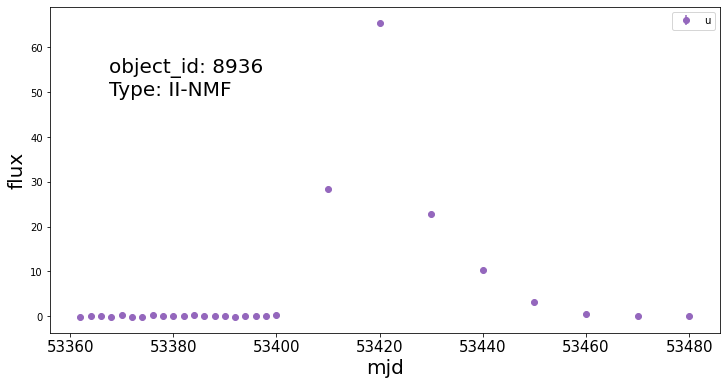

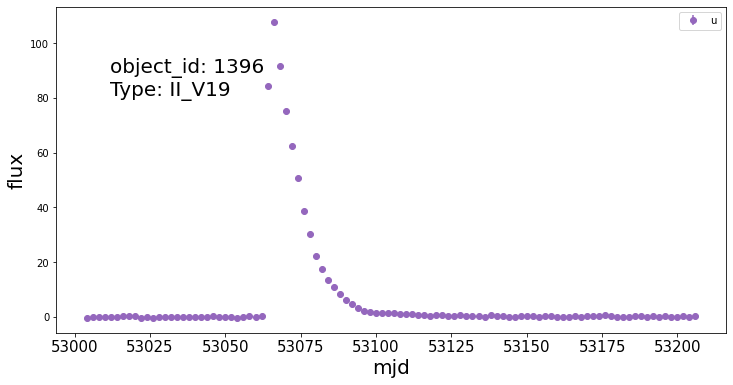

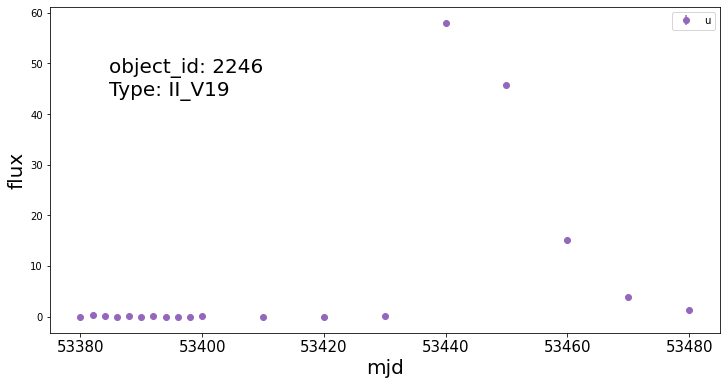

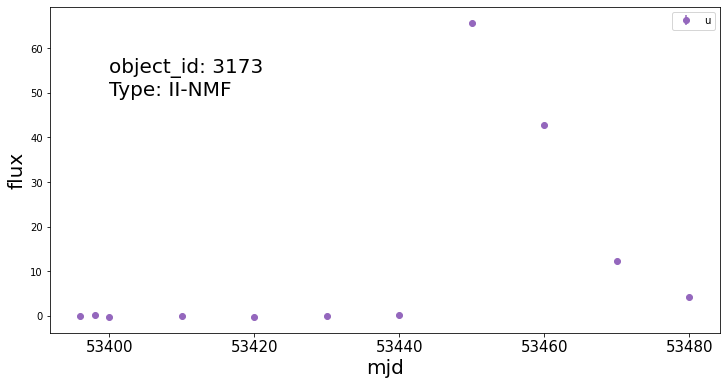

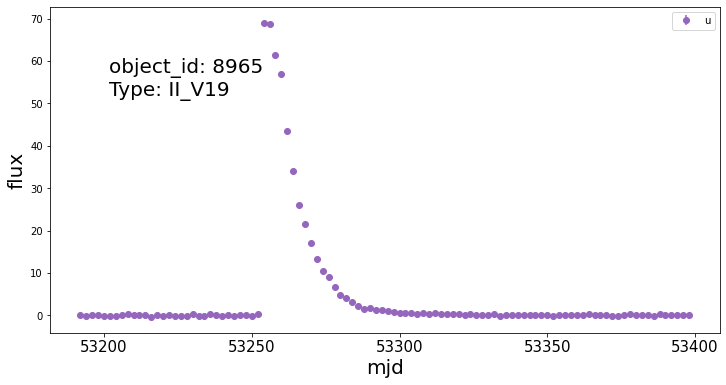

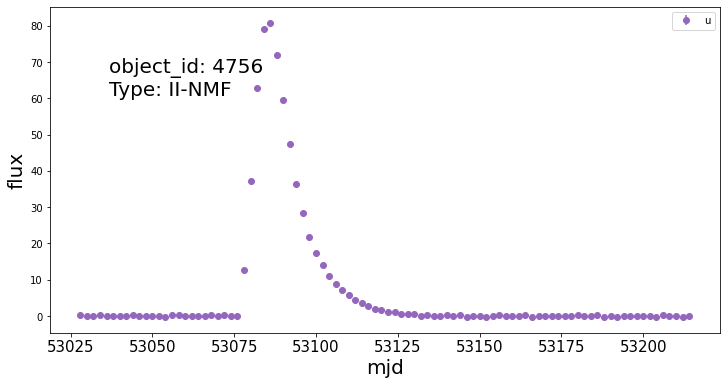

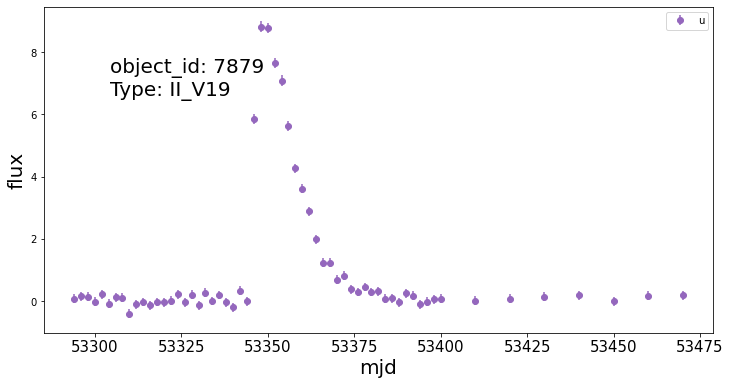

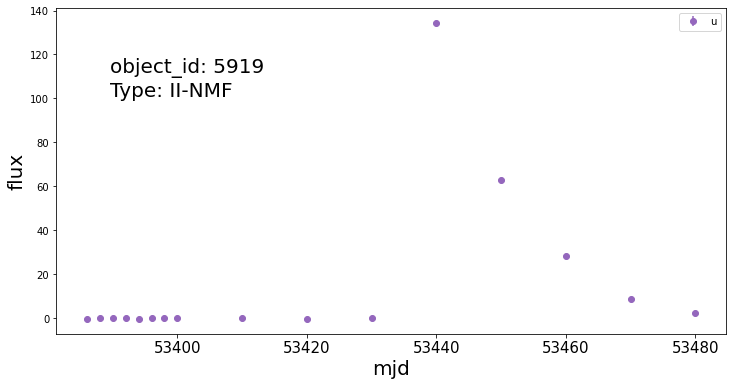

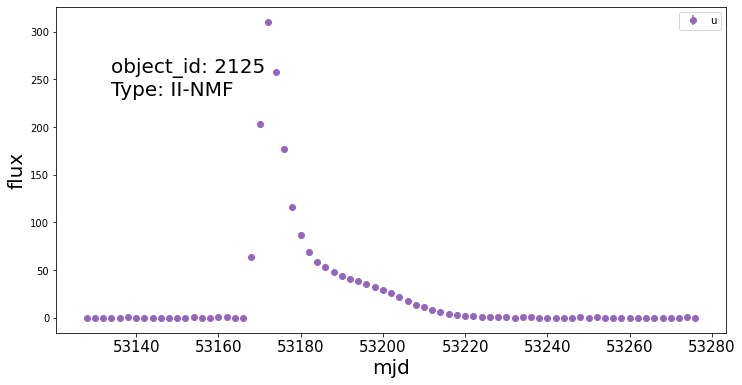

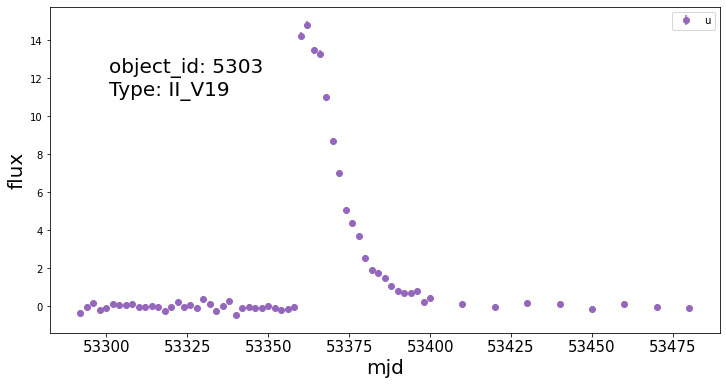

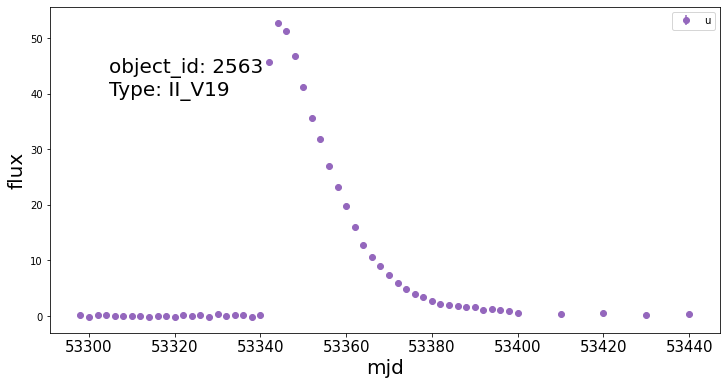

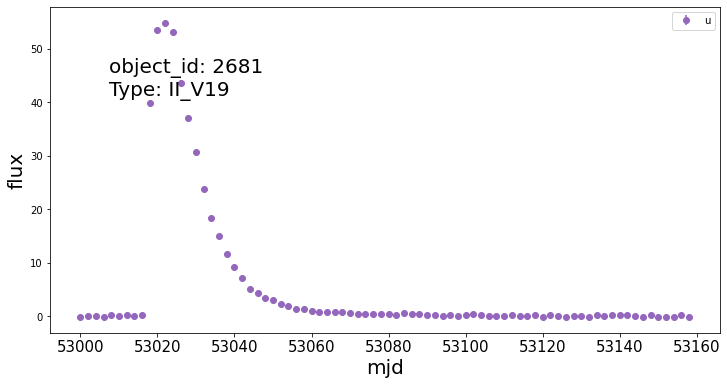

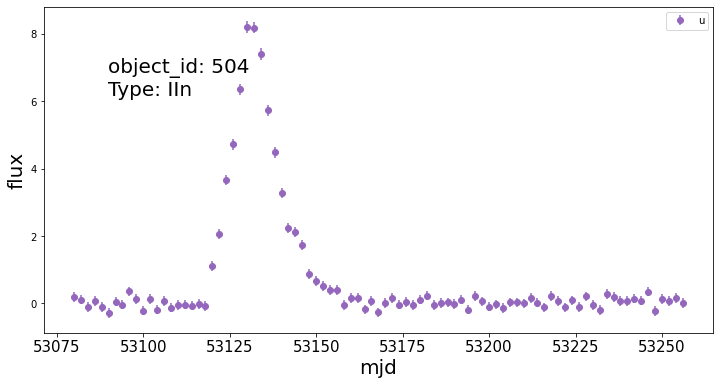

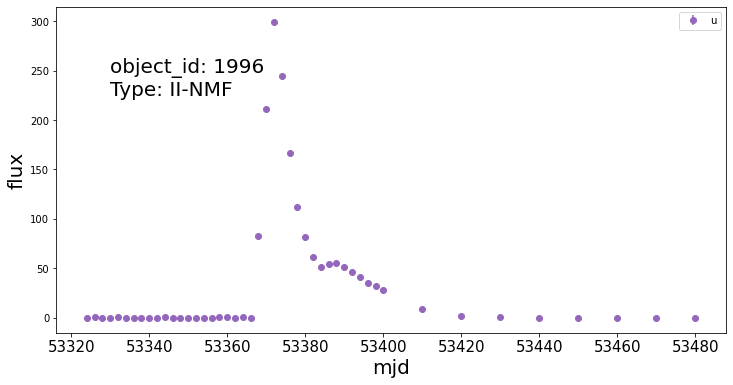

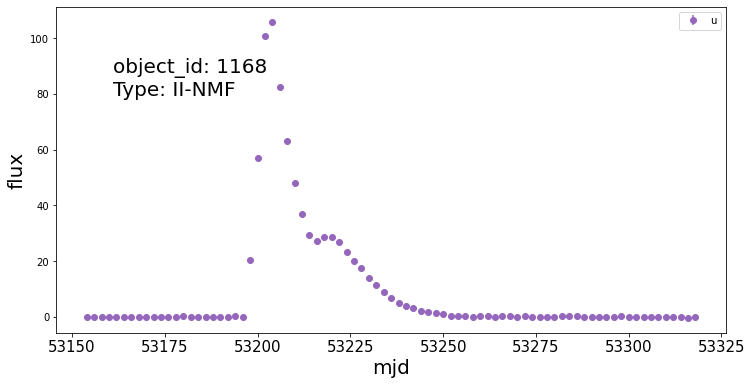

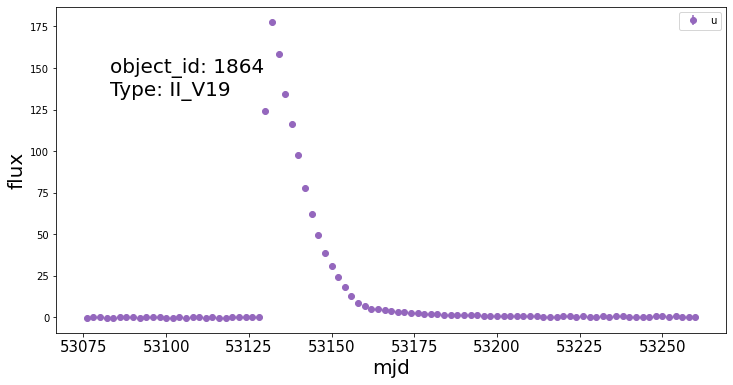

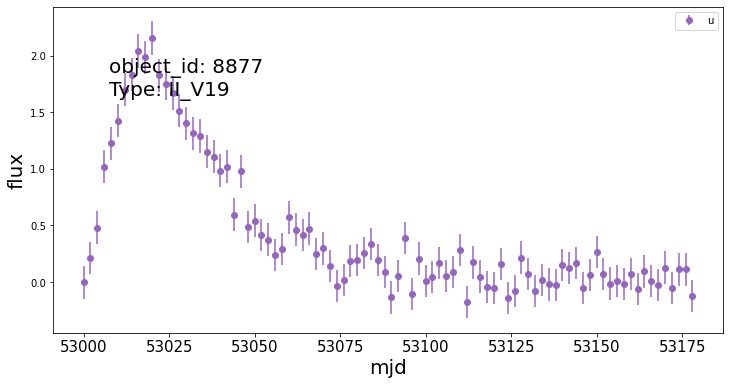

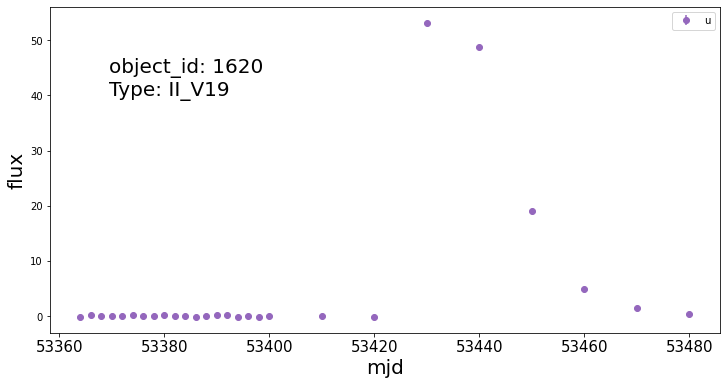

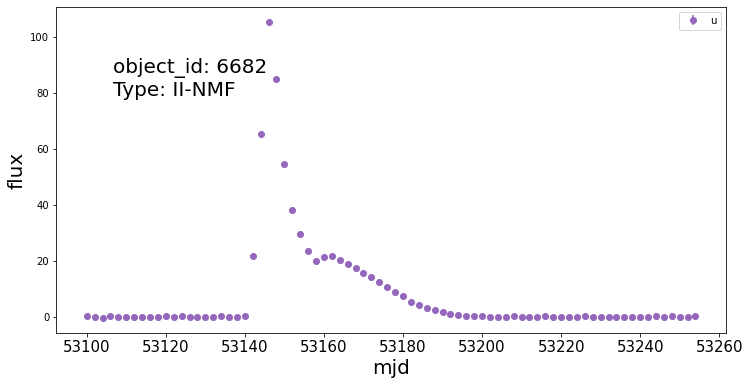

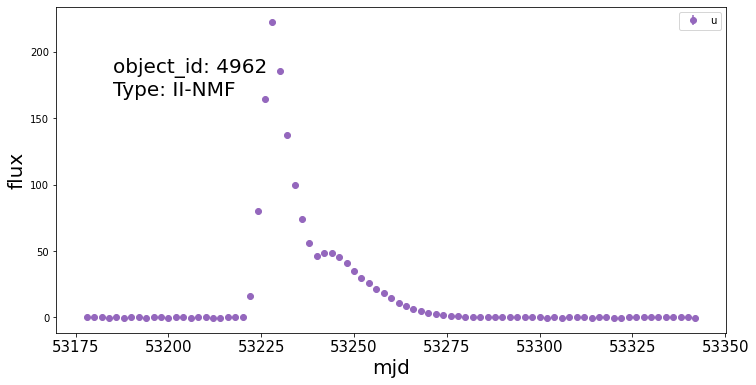

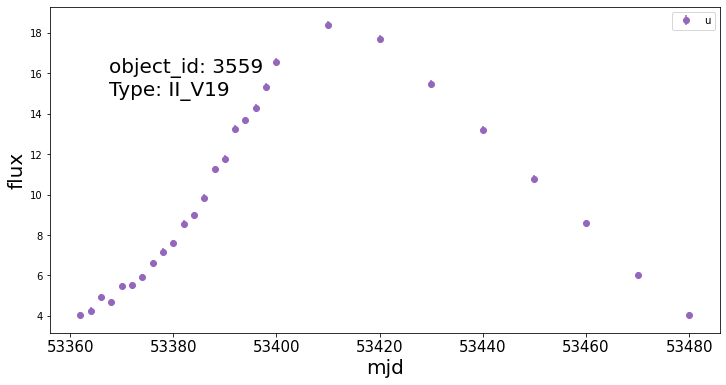

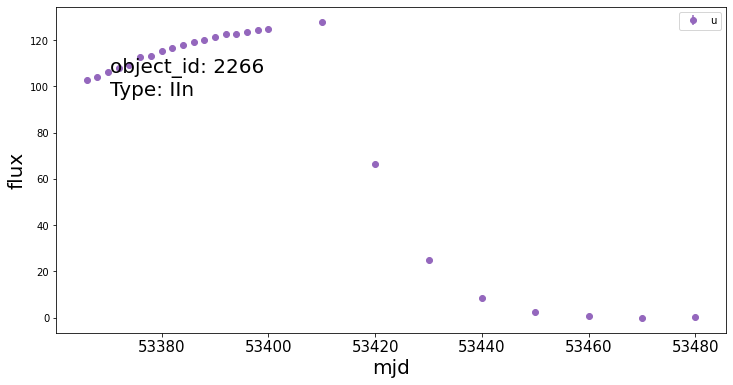

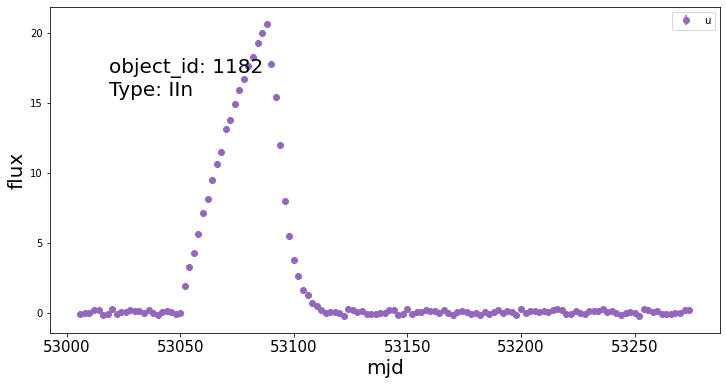

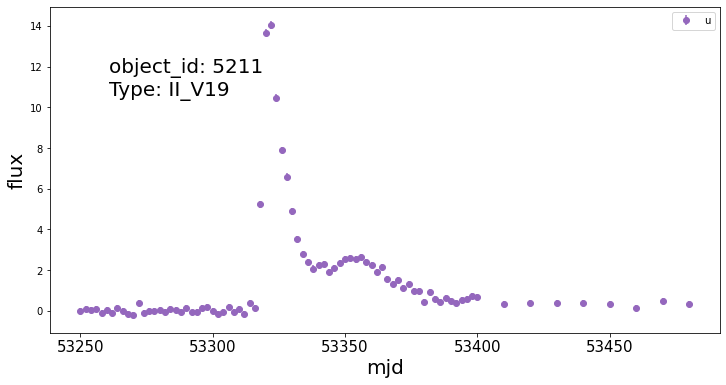

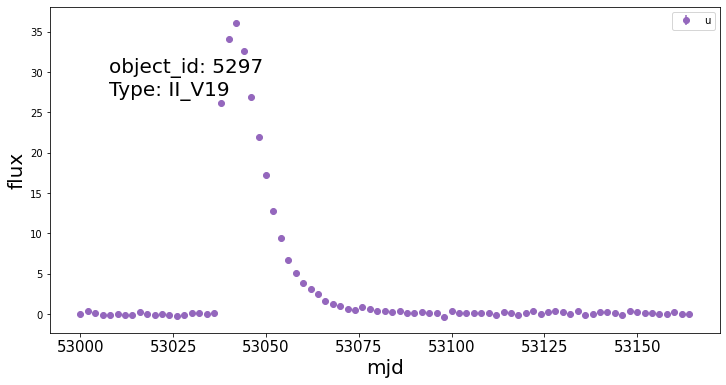

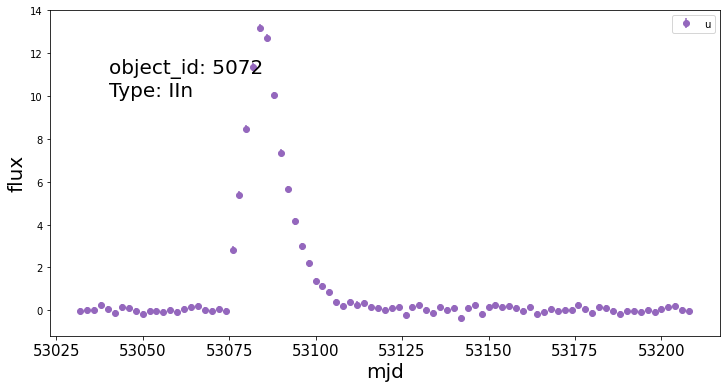

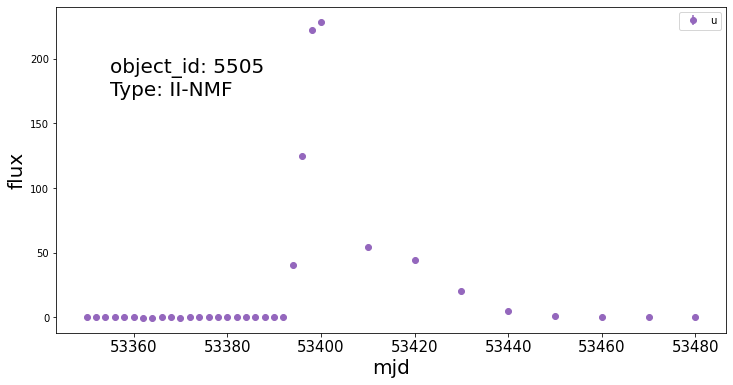

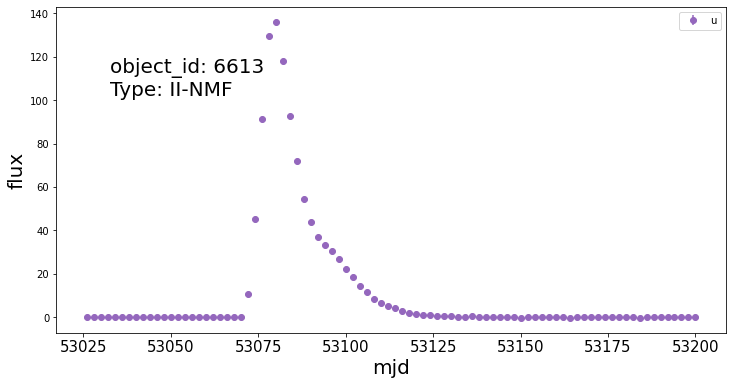

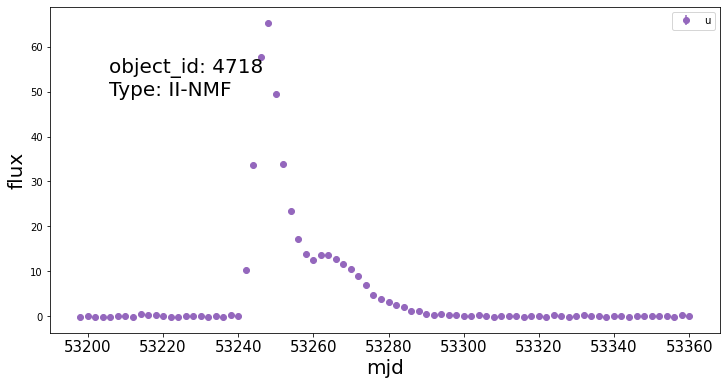

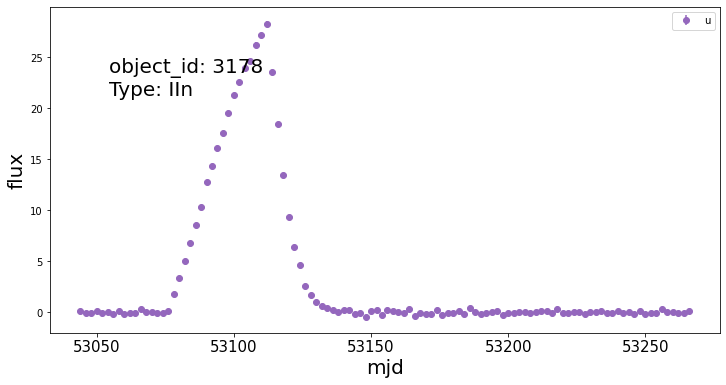

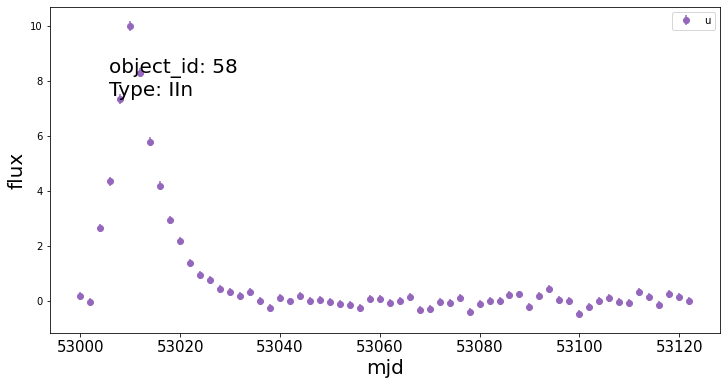

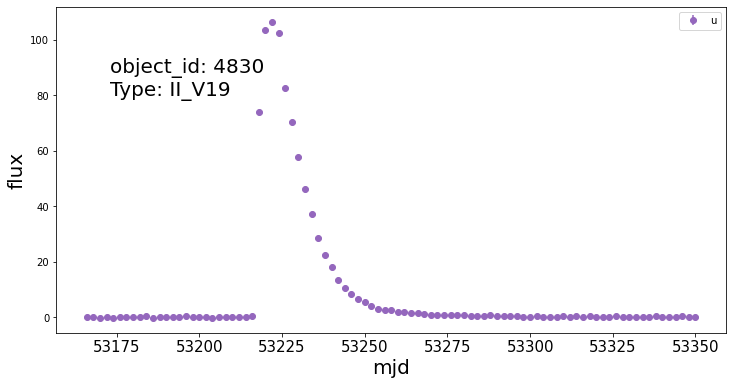

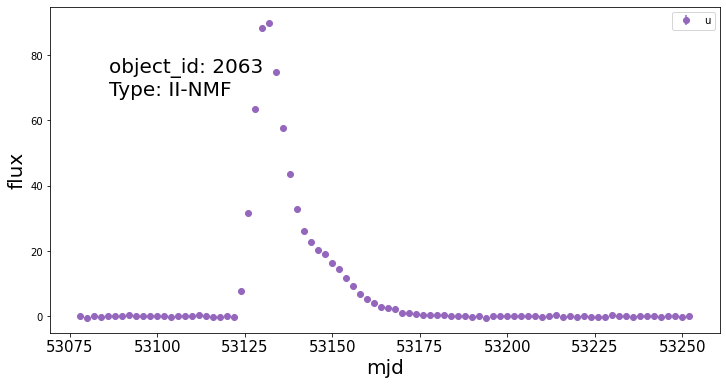

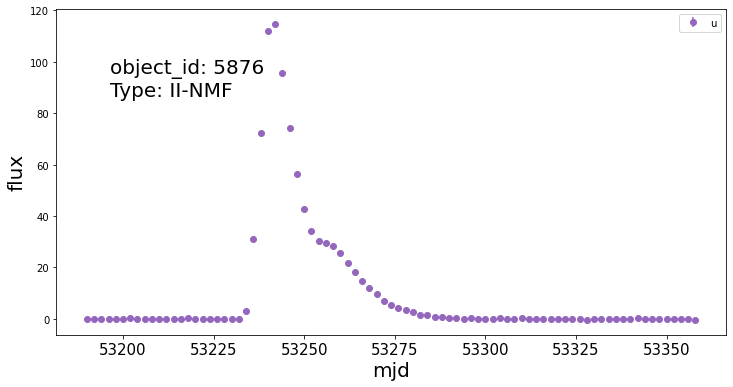

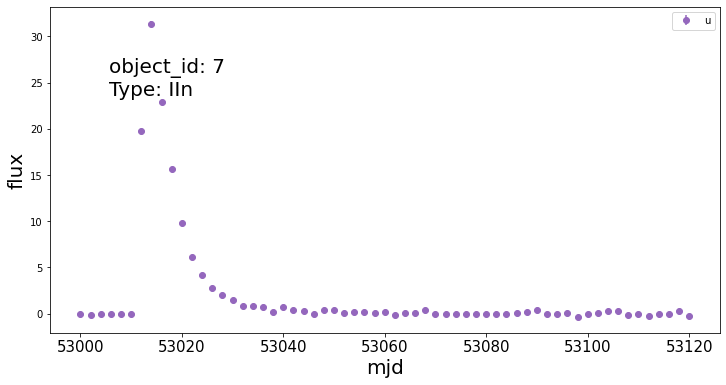

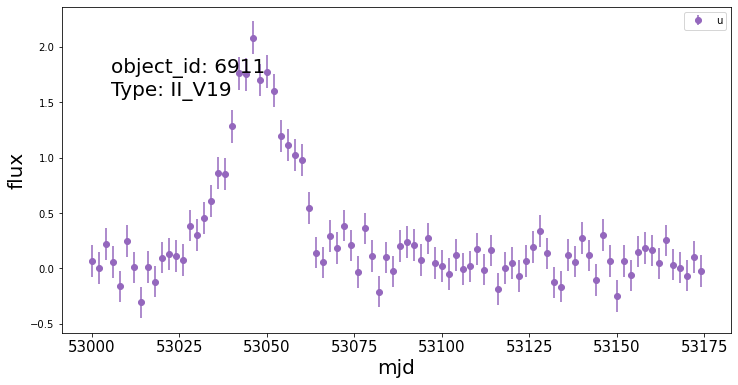

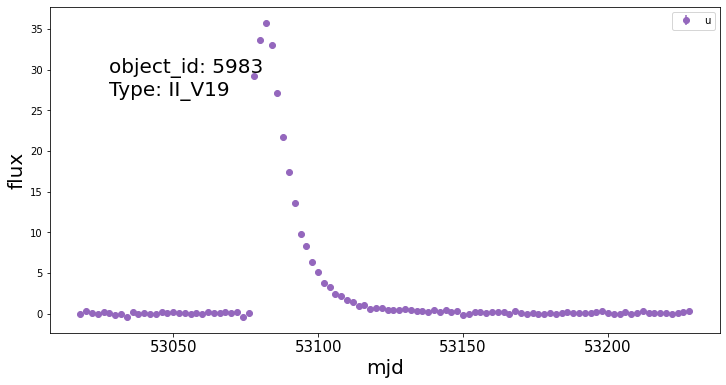

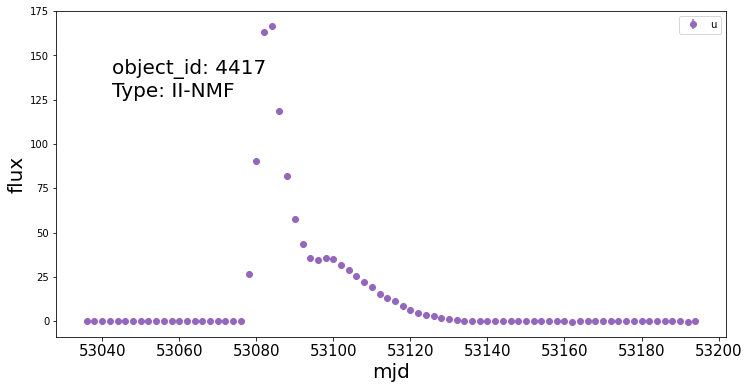

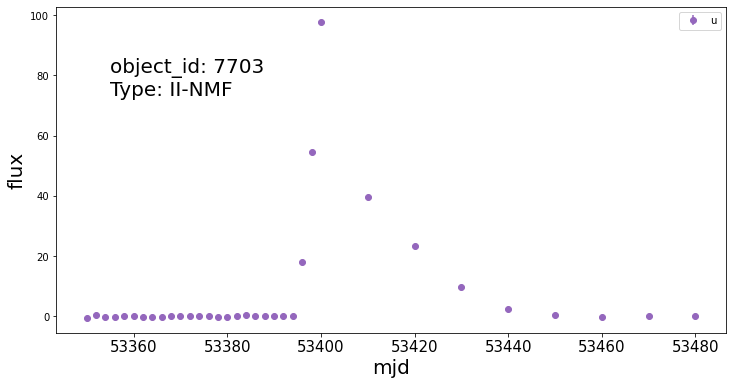

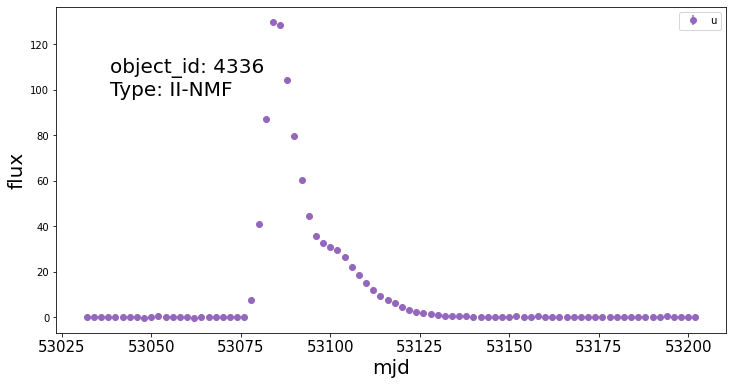

KeyboardInterrupt: 

In [6]:
for object_id in object_ids:
    lc = LightCurve(data_ob=data_ob, object_id=object_id)
    fig = lc.plot_light_curve(color_band_dict=color_band_dict, band ='u', mark_label=True, mark_maximum= False,plot_points =True)
    type_name = data_ob.df_metadata['type'][data_ob.df_metadata[data_ob.object_id_col_name] == object_id][0]
    plt.gca().annotate("object_id: "+str(int(object_id)), xy = (.15,.81), xycoords='figure fraction', fontsize=20)
    plt.gca().annotate("Type: "+type_name, xy = (.15,.75), xycoords='figure fraction', fontsize=20)
    plt.rc('xtick', labelsize = 15)
    fig.savefig("Perfect_plots/raw/id_"+str(int(object_id))+"_uband")
    plt.legend()
    plt.show()
    plt.close('all')

In [7]:
object_ids = np.sort(object_ids)

In [8]:
object_ids

array([2.000e+00, 3.000e+00, 4.000e+00, ..., 8.970e+03, 8.971e+03,
       8.973e+03])

In [9]:
from LightCurve import LightCurve

In [10]:
number_of_days_in_lc = 100
time_step=2

In [11]:
def get_alert_mid_pt(event_df, bands, current_date=None):
    
    if current_date is not None:
        date_difference = event_df[data_ob.time_col_name] - current_date
        past_index = (date_difference>=-50) & (date_difference<=0)
        event_df = event_df[past_index]
    
    band_mid_points = []
    for i,band in enumerate(bands):
        band_index = event_df[data_ob.band_col_name] == band
        band_df = event_df[band_index]
        
        PCs = np.load("PCs.npy")
        PCs = PCs[0:3]
        initial_guess = [.93,.03 ,.025]
        #regularization_base = [.93,.04,.012]
        if(len(band_df)>0):
            max_index = np.argmax(band_df[data_ob.flux_col_name])
            band_mid_points.append(band_df[data_ob.time_col_name][max_index])
    if len(band_mid_points)>0:
        return np.median(np.array(band_mid_points))
    else:
        return None

In [12]:
def gen_all_band_same_maxpt_PCs():

    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))

    for i,object_id in enumerate(object_ids):
        event_df = data_ob.get_data_of_event(object_id)
        mid_point = get_alert_mid_pt(event_df, data_ob.band_map.keys())
        print(mid_point)
        fig , ax = plt.figure((12,6))
        if mid_point is not None:

            start_date = mid_point-number_of_days_in_lc/2
            end_date = mid_point+number_of_days_in_lc/2

            start_index = event_df['MJD']>= start_date
            end_index = event_df['MJD'] <= end_date

            df_within_date = event_df[start_index*end_index]

            for band in data_ob.band_map.keys():

                band_df = df_within_date[df_within_date[data_ob.band_col_name] == band]

                if len(band_df)>0:

                    rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue



                    max_loc = int((mid_point-np.amin(band_df['MJD']))/2)
                    flux_data = np.zeros((51))
                    flux_data[25-max_loc:25-max_loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
                    ax.scatter(np.arange(0,102,2), flux_data,
                                color=color_band_dict[band], label=str(band))
        else: 
            continue

    return fig   
        
        
        

In [40]:
def gen_all_band_diff_maxpt_PCs():
    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))
        
    for i,object_id in enumerate(object_ids):
        print(object_id)
        event_df = data_ob.get_data_of_event(object_id)
        
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(1, 1, 1)
        for band in data_ob.band_map.keys():
            
            band_index = event_df[data_ob.band_col_name]==band
            band_df = event_df[band_index]
            
            if(len(band_df)>0):
                loc = np.argmax(band_df[data_ob.flux_col_name])
                mid_point = band_df[data_ob.time_col_name][loc]
                start_date = mid_point-number_of_days_in_lc/2
                end_date = mid_point+number_of_days_in_lc/2
                start_index = band_df['MJD']>= start_date
                end_index = band_df['MJD'] <= end_date


                band_df = band_df[start_index*end_index]
                if len(band_df)>0:
                    loc = np.argmax(band_df[data_ob.flux_col_name])
                    rand_int = int(random()*12)-2
                    #rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue

                    flux_data = np.zeros((51))
                    flux_data[25-loc:25-loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
                    x_data = np.arange(0,102,2)
                    print(np.argmax(flux_data))
                    if band == 'u':
                        ax.scatter(np.arange(0,102,2), flux_data, color=color_band_dict[band], label=band)
                    
                    
                    
                    
                    
        type_name = data_ob.df_metadata['type'][data_ob.df_metadata[data_ob.object_id_col_name] == object_id][0]
        #plt.gca().annotate("object_id: "+str(int(object_id)), xy = (.15,.81), xycoords='figure fraction', fontsize=20)
        #plt.gca().annotate("Type: "+type_name, xy = (.15,.75), xycoords='figure fraction', fontsize=20)
        #ax.axvline(x=50,ymin=0,ymax=1,label="Day 50",linestyle = "--")
        #plt.xlabel("Days", fontsize=20)
        #plt.ylabel("Flux", fontsize=20)
        #plt.rc("xtick", labelsize=15)
        #ax.legend()
        #fig.savefig("Perfect_plots/shifted/id_"+str(int(object_id))+"_uband")
        #plt.show()
        plt.close('all')

                    
    return final_array

In [2]:
object_ids = np.sort(object_ids)

NameError: name 'np' is not defined

In [14]:
print(object_ids)

[6612. 7860. 3421. ... 8618. 2861. 8940.]


In [41]:
final_array = gen_all_band_diff_maxpt_PCs()
#plt.show()
plt.close('all')
#print(final_array.keys())

6612.0
27
32
27
25
31
24
7860.0
34
33
24
32
25
32
3421.0
25
23
32
30
26
26
3368.0
30
30
26
28
34
26
3200.0
30
28
27
28
29
32
2478.0
33
28
30
24
31
34
1640.0
24
23
25
27
32
32
6509.0
24
27
26
29
28
28
2002.0
34
23
28
31
29
23
5537.0
26
30
24
27
26
26
8018.0
25
25
27
27
24
30
1621.0
24
24
28
32
30
30
7553.0
27
29
23
32
30
27
6172.0
24
28
24
32
34
30
8653.0
23
24
24
19
27
29
2980.0
26
34
26
28
28
29
8936.0
22
25
24
24
24
22
1396.0
30
24
23
33
26
30
2246.0
29
25
27
23
3173.0
28
23
27
0
26
8965.0
26
27
31
27
32
31
4756.0
33
29
26
28
24
27
7879.0
24
29
31
27
30
28
5919.0
23
28
28
28
26
2125.0
24
23
32
28
33
29
5303.0
23
30
24
30
27
23
2563.0
23
24
29
29
24
25
2681.0
33
34
34
32
29
27
504.0
34
23
26
29
33
31
1996.0
23
26
25
29
26
25
1168.0
26
27
28
29
26
32
1864.0
33
23
33
31
25
25
8877.0
27
26
24
34
24
32
1620.0
24
28
26
28
28
23
6682.0
26
25
26
24
30
31
4962.0
24
26
25
26
28
30
3559.0
29
30
28
23
26
29
2266.0
25
30
30
25
23
30
1182.0
23
34
25
32
33
30
5211.0
34
33
23
34
32
30
5297.0
32
25
2

27
28
25
26
26
27
8403.0
26
32
26
25
26
30
8630.0
28
25
26
26
27
0
2230.0
31
23
26
30
27
24
6362.0
26
33
31
31
29
32
907.0
32
23
32
27
25
27
92.0
32
23
30
32
33
34
2896.0
25
27
31
33
32
26
5641.0
32
26
25
29
27
28
1734.0
30
32
24
30
29
32
1359.0
24
29
27
33
27
23
3585.0
34
28
27
25
25
33
7418.0
29
28
18
28
23
0
36.0
28
33
32
25
26
27
6962.0
23
30
34
23
26
30
5105.0
27
29
32
24
30
32
8741.0
24
31
32
32
25
34
986.0
23
24
28
32
32
31
383.0
25
25
34
29
23
25
7091.0
26
25
24
32
29
25
2999.0
25
29
19
27
26
29
4161.0
24
25
24
23
4721.0
29
24
33
28
30
24
7457.0
34
30
31
25
26
32
4510.0
24
32
26
34
33
29
2777.0
24
32
30
29
26
27
5337.0
27
33
32
29
32
24
6756.0
31
24
31
31
27
30
5215.0
31
33
25
27
30
33
6966.0
24
28
23
28
27
31
4685.0
33
32
25
27
23
30
4297.0
33
24
24
33
25
27
3488.0
33
33
26
28
29
24
57.0
29
34
34
23
31
30
3383.0
25
31
27
28
24
31
6001.0
26
31
34
31
25
25
3017.0
29
33
33
25
30
32
5183.0
27
27
25
29
32
23
3943.0
34
34
26
25
27
28
6485.0
33
29
24
29
30
27
3693.0
23
33
25
34
25
30

24
25
28
34
29
23
7049.0
24
29
29
32
32
34
5704.0
33
33
23
27
33
30
7768.0
24
27
29
27
29
29
309.0
29
25
32
24
27
29
994.0
31
31
30
27
30
32
4281.0
29
23
33
30
34
24
3817.0
24
34
31
24
31
31
1852.0
29
23
34
30
23
27
6380.0
26
32
28
29
27
32
3862.0
29
32
26
30
23
24
4164.0
31
29
28
26
27
32
1667.0
32
23
30
27
31
30
4132.0
29
33
30
23
25
23
7286.0
28
28
22
28
24
27
2697.0
28
32
29
24
25
23
1696.0
31
29
25
33
32
32
3678.0
33
29
25
25
23
34
867.0
23
30
25
34
25
28
7266.0
34
23
32
30
28
26
1013.0
29
27
25
31
34
24
4820.0
33
26
26
31
25
33
8250.0
25
24
25
29
30
30
4866.0
33
30
31
27
34
24
3783.0
31
32
34
24
28
31
1671.0
28
28
28
25
24
5012.0
25
29
24
24
34
23
154.0
25
25
0
28
26
28
4046.0
33
33
34
24
23
31
1378.0
29
25
26
32
34
28
1255.0
32
26
32
26
28
23
4137.0
28
25
24
23
29
33
5436.0
30
31
27
33
28
28
6471.0
34
27
24
32
30
31
594.0
25
33
23
30
27
29
1603.0
28
27
27
25
2634.0
23
0
26
24
0
0
6973.0
24
27
30
30
30
25
6782.0
24
28
24
22
27
29
8652.0
29
32
29
28
31
24
5360.0
23
26
24
28
27
29


29
33
32
28
31
30
3118.0
25
25
25
29
28
26
313.0
27
27
27
34
24
28
1736.0
26
23
32
33
27
27
2726.0
27
31
34
30
29
25
1860.0
26
27
34
34
23
25
2069.0
23
31
30
28
24
23
8744.0
30
24
28
25
30
23
6272.0
32
31
32
34
32
34
5422.0
28
25
30
25
31
23
4357.0
25
29
27
29
26
26
6965.0
29
25
26
31
25
34
2222.0
26
28
28
30
27
27
1436.0
33
28
33
32
24
28
1754.0
31
28
33
33
34
31
2675.0
28
28
28
33
30
32
4893.0
33
34
33
28
31
31
4801.0
27
26
34
26
25
23
8342.0
24
24
30
31
25
31
7071.0
34
25
23
29
27
29
8184.0
25
30
25
31
31
31
2898.0
34
26
29
30
32
33
4967.0
27
28
34
26
26
24
3374.0
26
29
30
29
26
23
7995.0
33
34
23
25
23
23
8642.0
31
33
25
23
31
34
1613.0
33
34
33
23
26
23
5673.0
30
29
32
23
23
29
4332.0
33
32
29
30
33
26
6139.0
33
23
27
29
34
27
2071.0
27
23
23
25
27
27
113.0
23
31
30
29
29
31
6531.0
23
32
34
30
26
24
7375.0
23
24
23
29
26
29
6404.0
29
32
27
25
28
30
4684.0
24
25
33
34
29
31
5671.0
25
24
23
31
24
23
4602.0
25
29
29
34
28
26
743.0
25
25
24
5213.0
30
28
27
25
24
33
3431.0
32
28
33
31


25
23
24
24
26
32
7159.0
29
33
29
27
27
31
8469.0
26
19
26
23
25
20
3447.0
26
30
30
27
30
28
4857.0
24
33
31
33
32
29
2118.0
0
28
27
26
27
27
6620.0
28
24
32
28
33
31
5598.0
29
25
27
25
30
27
6368.0
28
24
31
30
34
25
96.0
29
25
25
28
23
31
2317.0
30
34
29
30
24
33
7660.0
32
31
27
27
30
32
5559.0
33
23
24
25
33
23
289.0
31
32
27
34
34
34
345.0
23
27
29
33
29
26
5130.0
33
34
27
29
30
34
234.0
23
29
25
23
29
29
5336.0
23
27
24
30
30
30
3462.0
33
31
28
28
33
26
7016.0
33
23
33
24
33
23
512.0
24
29
25
24
23
30
770.0
30
32
27
34
25
23
7365.0
26
32
24
26
31
30
5301.0
33
33
23
29
27
30
8828.0
32
29
26
30
32
29
5567.0
30
29
24
23
30
26
7529.0
34
24
34
26
26
34
3772.0
32
31
33
31
32
33
6881.0
31
30
29
28
34
31
3417.0
27
24
28
31
29
25
3182.0
30
28
29
26
24
33
3193.0
28
23
24
27
28
23
4947.0
33
34
25
30
31
26
7678.0
26
31
27
25
23
32
2796.0
25
28
24
27
33
30
1641.0
28
28
26
25
26
30
5661.0
34
28
33
33
24
30
1338.0
30
30
25
29
26
32
7136.0
25
27
25
30
26
33
3457.0
24
28
23
24
34
24
8701.0
30
26
23

25
34
33
30
30
32
3572.0
27
26
33
25
23
31
7377.0
25
29
28
32
23
34
4243.0
30
29
23
21
25
28
3146.0
32
27
25
33
29
32
1839.0
25
27
23
24
28
32
5133.0
26
34
33
32
30
24
3125.0
27
28
23
33
28
27
4582.0
29
25
23
28
25
30
7602.0
34
24
34
33
23
30
5595.0
32
31
25
32
28
26
8258.0
28
31
34
29
29
34
3892.0
29
28
25
31
28
34
4693.0
28
26
26
31
23
29
5416.0
34
24
28
28
24
26
1354.0
26
29
26
25
25
0
2938.0
34
23
31
32
31
31
4021.0
28
30
32
27
33
34
3127.0
25
27
24
27
27
27
5390.0
24
34
27
34
33
23
5421.0
30
31
28
33
33
33
507.0
29
34
31
32
27
32
7885.0
31
34
24
28
30
27
5999.0
25
28
28
34
34
24
7252.0
24
30
24
23
29
29
5063.0
28
32
29
28
30
29
6206.0
26
30
24
28
25
31
7586.0
25
29
26
25
32
24
1296.0
32
33
34
27
33
31
2339.0
33
29
26
31
32
28
8073.0
34
28
24
26
28
34
2670.0
31
24
24
30
24
26
3930.0
33
28
30
24
23
30
2691.0
23
34
34
25
29
26
7098.0
26
28
29
34
31
33
3778.0
23
28
20
29
23
26
1187.0
32
30
27
25
27
30
8753.0
28
31
30
26
26
29
2613.0
23
31
24
31
32
25
6674.0
27
27
23
24
24
24
2869.0
32

23
26
24
6796.0
29
27
28
34
33
26
1346.0
28
34
29
25
28
26
8222.0
33
25
30
28
33
31
4325.0
30
27
34
27
23
24
4958.0
24
25
23
25
26
30
5036.0
30
30
26
27
33
34
8738.0
30
28
30
33
25
28
6870.0
34
29
26
32
23
27
5922.0
29
23
28
29
31
26
8214.0
27
34
28
29
27
33
7572.0
29
28
27
26
25
3090.0
32
24
29
27
29
23
857.0
31
24
29
32
26
23
6890.0
27
28
28
28
23
31
2899.0
25
24
34
31
25
28
2917.0
31
27
23
26
25
28
3571.0
29
31
34
26
33
31
2984.0
33
30
27
29
30
30
4419.0
34
29
34
34
26
29
6539.0
23
30
29
30
25
30
1865.0
32
29
25
24
23
32
1650.0
26
28
29
32
26
33
2048.0
33
28
27
27
29
26
2524.0
29
23
32
33
25
32
7081.0
17
28
26
25
30
29
2003.0
25
29
30
31
33
31
5344.0
23
30
28
30
29
29
2251.0
32
28
23
29
24
29
5631.0
25
34
25
32
26
33
2733.0
32
28
29
29
32
27
8717.0
29
30
28
21
23
28
1163.0
30
24
24
26
29
32
6066.0
34
34
28
33
34
32
3893.0
31
32
25
27
23
31
6616.0
32
30
29
24
29
23
8732.0
26
29
25
24
25
27
6258.0
23
23
33
29
32
24
8550.0
29
28
34
33
26
24
7566.0
29
28
33
26
29
28
5894.0
30
34
31
25
3

26
27
26
24
1438.0
23
25
30
30
25
25
6427.0
25
26
33
24
29
26
52.0
33
34
26
26
33
30
1928.0
28
34
26
33
28
28
3206.0
23
33
25
28
25
27
5002.0
27
26
26
27
32
30
2086.0
14
26
30
27
20
30
7609.0
30
26
31
23
26
29
1503.0
34
30
25
29
25
32
1165.0
31
26
23
30
31
31
1041.0
32
33
23
30
27
26
1797.0
23
29
33
24
33
32
8405.0
27
34
30
34
23
32
3560.0
30
29
27
26
27
25
8207.0
30
24
31
33
29
26
3446.0
23
28
29
31
34
23
3881.0
27
26
30
34
23
33
912.0
32
27
24
29
32
34
8837.0
30
30
29
23
29
30
3626.0
25
24
30
24
30
29
5989.0
34
32
27
34
31
24
1931.0
23
26
26
30
30
28
5077.0
32
34
30
23
24
27
8369.0
28
27
28
31
29
26
8707.0
32
31
34
31
31
32
579.0
26
30
26
29
32
34
5331.0
33
24
26
23
25
29
2240.0
26
29
23
27
30
26
7820.0
26
26
23
30
30
23
6349.0
26
29
34
29
27
32
2828.0
25
29
31
25
30
27
4924.0
31
34
31
25
31
29
4138.0
27
24
24
31
28
28
1775.0
24
26
32
30
27
31
7463.0
29
32
24
24
28
34
3834.0
33
27
33
34
29
34
8494.0
31
27
24
34
24
34
4775.0
31
28
32
32
31
27
4222.0
23
31
31
29
28
34
4606.0
28
33
24
2

25
4822.0
27
30
24
27
32
27
2716.0
27
34
34
27
25
33
7813.0
28
27
27
25
27
8952.0
29
30
33
32
29
23
4592.0
28
34
27
28
25
33
5144.0
34
25
26
26
33
26
2374.0
32
26
27
26
30
29
5437.0
27
34
26
33
31
32
7835.0
28
33
32
33
25
27
4039.0
26
28
26
33
23
28
407.0
33
28
28
33
25
29
4580.0
25
32
28
24
23
26
7780.0
31
26
25
25
28
30
8197.0
32
24
25
33
26
27
2068.0
31
26
31
25
27
23
4741.0
27
34
34
34
29
33
1055.0
24
23
28
26
23
251.0
25
29
28
24
34
24
7944.0
30
33
30
24
25
34
6481.0
34
29
26
27
28
34
6479.0
32
33
24
32
28
28
5410.0
33
28
23
28
25
28
8724.0
23
29
25
23
28
30
332.0
25
30
26
27
26
27
7986.0
29
24
27
23
26
27
5383.0
33
34
32
30
25
34
1157.0
27
25
25
30
30
28
4654.0
29
23
25
31
33
31
5249.0
32
31
34
23
27
31
4449.0
24
31
34
23
29
26
5709.0
29
24
34
33
28
31
3723.0
25
24
25
25
23
32
8568.0
27
34
26
33
23
29
3548.0
27
26
28
30
27
30
1582.0
24
23
31
27
25
23
4388.0
25
30
34
31
28
29
8666.0
30
29
28
32
33
31
6654.0
29
33
34
31
29
27
2121.0
31
26
27
30
32
25
5846.0
23
31
34
23
26
29
2531.0

24
30
32
32
34
23
1460.0
28
32
26
31
25
33
3830.0
27
23
25
30
30
29
8688.0
30
24
26
33
33
29
364.0
25
23
28
32
27
32
8031.0
21
28
25
24
0
3101.0
33
31
33
34
29
26
7968.0
34
29
26
29
30
34
7904.0
27
23
23
27
25
28
4103.0
25
23
31
28
27
28
2516.0
26
29
29
28
32
27
3807.0
27
24
32
25
28
32
1206.0
24
28
29
27
29
33
7694.0
26
25
26
0
25
1067.0
24
25
28
30
27
30
4574.0
27
32
34
24
26
31
119.0
24
23
32
23
23
24
6425.0
30
33
32
31
34
27
1425.0
32
28
25
27
31
28
3394.0
23
26
31
32
33
24
4486.0
30
32
25
32
23
32
836.0
23
24
23
32
34
25
6410.0
28
32
32
25
28
27
388.0
31
33
26
25
30
34
550.0
27
31
27
24
23
32
952.0
25
28
31
24
30
26
5236.0
33
30
29
34
26
28
5076.0
27
30
26
23
25
34
5200.0
25
26
33
33
23
23
4416.0
28
25
29
32
32
31
4397.0
29
24
24
24
29
30
5687.0
29
24
27
25
34
29
3254.0
26
30
28
31
23
28
7825.0
25
34
23
30
27
29
1728.0
27
20
30
28
30
27
6304.0
34
33
25
23
26
30
6856.0
24
33
30
34
31
27
3911.0
29
24
24
0
28
25
1040.0
23
27
29
34
31
27
111.0
34
31
32
26
23
28
525.0
29
30
34
28
28
34

27
30
25
34
24
26
1162.0
30
28
31
30
25
23
1968.0
34
34
29
23
31
28
5587.0
33
30
30
34
32
29
3339.0
23
25
31
23
33
31
291.0
32
33
25
23
31
24
6942.0
25
26
30
25
28
34
1466.0
28
23
30
26
28
24
6270.0
28
23
27
34
29
30
8326.0
28
30
34
30
23
30
1863.0
34
28
34
30
24
25
524.0
30
32
26
27
23
23
6355.0
34
30
28
31
31
28
7277.0
34
24
30
25
31
34
8661.0
31
23
28
27
29
23
2133.0
29
24
30
26
30
23
6993.0
18
26
27
23
29
24
2187.0
25
25
33
29
31
28
6127.0
28
32
25
32
23
31
6622.0
28
24
26
24
23
30
3932.0
23
33
31
24
27
23
8256.0
23
23
23
23
27
31
1122.0
25
30
32
33
28
28
5138.0
28
29
29
28
23
28
4555.0
24
23
25
24
23
32
4255.0
24
24
27
0
0
5408.0
25
30
30
23
26
30
5491.0
26
25
32
24
28
25
2161.0
23
24
25
32
28
33
2868.0
33
29
31
30
30
24
5954.0
28
33
31
26
34
26
855.0
25
32
29
24
24
32
194.0
25
26
32
30
31
29
6229.0
23
25
27
29
26
27
8957.0
24
26
27
24
28
30
7833.0
24
25
31
28
29
28
8059.0
31
27
23
28
30
30
3252.0
23
24
29
29
23
29
7306.0
30
30
24
23
33
23
8304.0
23
29
30
34
23
34
4942.0
32
23
25


25
27
24
29
29
28
6716.0
26
23
24
24
28
30
6685.0
23
24
28
24
34
28
7458.0
32
23
25
25
26
26
3306.0
34
24
24
34
28
31
8329.0
30
29
23
23
33
32
6291.0
25
33
30
30
27
32
5736.0
29
26
33
28
34
34
1221.0
32
32
32
32
32
26
6841.0
29
23
32
34
23
29
3138.0
25
34
34
27
25
34
6585.0
29
34
28
30
27
27
2977.0
29
25
33
26
24
31
4523.0
27
29
28
32
26
30
2599.0
28
28
23
23
30
32
6164.0
30
30
25
28
27
24
7889.0
32
32
24
24
31
24
1099.0
30
24
32
31
25
27
6872.0
24
29
31
33
24
32
5940.0
32
31
33
34
31
32
5151.0
23
23
32
33
34
24
4931.0
27
26
33
28
23
34
835.0
25
28
32
27
33
33
2226.0
25
24
30
26
29
24
900.0
27
27
32
32
25
24
4715.0
27
33
25
29
34
31
8677.0
25
30
23
29
30
31
2523.0
25
25
33
26
33
24
3395.0
25
25
34
34
30
33
5498.0
25
28
31
28
24
23
6478.0
27
25
24
26
32
23
8581.0
29
26
32
26
29
25
6690.0
27
26
27
28
30
33
4005.0
26
30
31
29
26
34
4842.0
24
27
33
25
32
32
8840.0
26
32
29
26
31
26
2231.0
23
27
0
24
26
3433.0
27
27
30
25
24
29
6714.0
28
33
33
34
25
24
4730.0
27
24
33
27
33
32
7818.0
28
28


In [42]:
from sklearn.decomposition import PCA

In [43]:
color_band_dict['u']

'C4'

In [44]:
final_arr

NameError: name 'final_arr' is not defined

In [45]:
def gen_PC_diff_bands():
    PC_dict = {}
    for pb_name in data_ob.band_map.keys():
        pca = PCA(n_components=10)
        pca.fit(final_array[pb_name])
        PC_dict[pb_name] = pca.components_
        print(pca.explained_variance_ratio_)
        print(PC_dict[pb_name].shape)
        del pca
    return PC_dict

In [49]:
def gen_PC_mixed_bands():
    PC_dict = {}
    final_arr = []
    for pb_name in data_ob.band_map.keys():
        final_arr.extend(final_array[pb_name])
    pca = PCA(n_components=10)
    pca.fit(final_arr)
    PC_dict['all'] = pca.components_
    print(pca.explained_variance_ratio_)
    return pca, PC_dict

[0.79035612 0.11836997 0.04616642 0.01843075 0.0094039  0.00449063
 0.00311354 0.00200716 0.00163611 0.0011181 ]


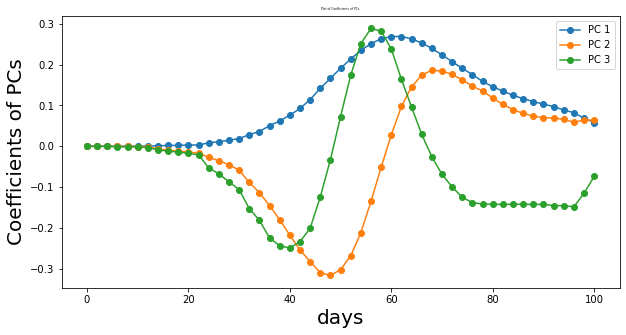

In [50]:
pca, PC_dict = gen_PC_mixed_bands()
band = 'all'
PCs= PC_dict[band]
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("Coefficients of PCs", fontsize=20)
#print(band)
plt.legend()
plt.title("Plot of Coefficients of PCs",fontsize=3)
#fig.savefig("Plot of PCs")
plt.show()

In [31]:
print(PC_dict.keys())

dict_keys(['u', 'g', 'r', 'i', 'z', 'Y'])


In [32]:
data_ob.band_map.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'Y'])

u
u


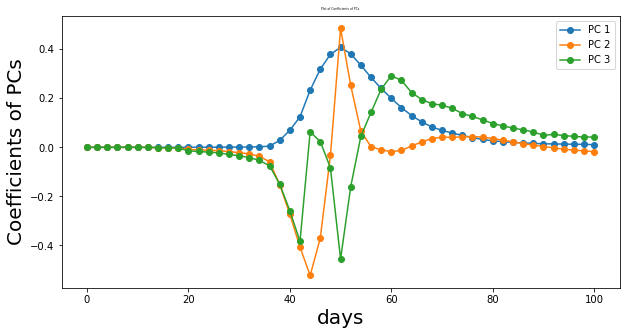

g
g


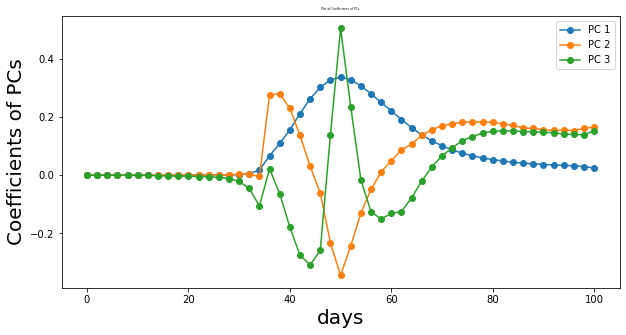

r
r


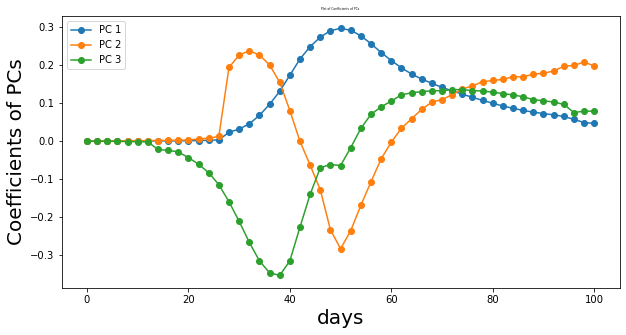

i
i


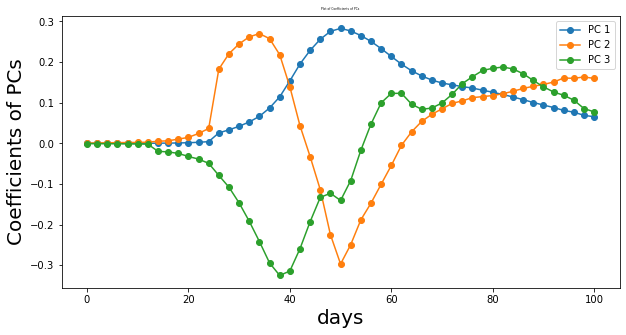

z
z


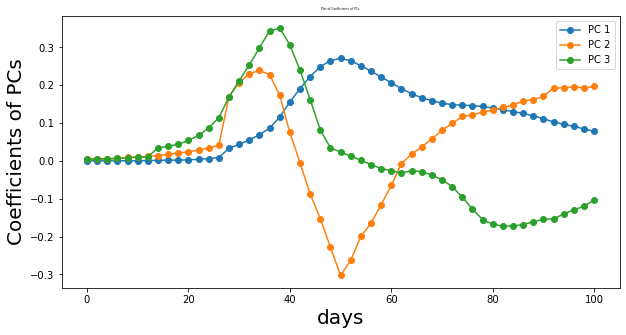

Y
Y


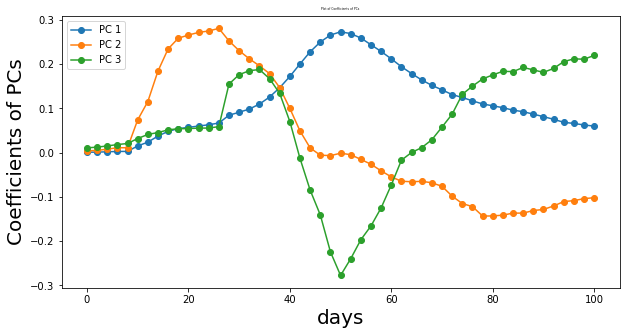

In [34]:
for band in data_ob.band_map.keys():
    print(band)
    PCs= PC_dict[band]
    fig = plt.figure(figsize=(10,5))
    for i in range(3):
        PC = PCs[i]
        x = np.arange(0,102,2)
        plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

    plt.xlabel("days", fontsize = 20)
    plt.ylabel("Coefficients of PCs", fontsize=20)
    print(band)
    plt.legend()
    plt.title("Plot of Coefficients of PCs",fontsize=3)
    #fig.savefig("Plot of PCs")
    plt.show()

In [ ]:
#np.save("principal_components/PC_all_bands_diff_mid_pt_dict", PC_dict)

In [ ]:
print(PC_dict['u'][0:3])

In [ ]:
for object_id in object_ids:
    event_df = data_ob.get_data_of_event(object_id)
    lc = LightCurve(data_ob.get_data_of_event(object_id), time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    fig = lc.plot_light_curve(color_band_dict, alpha = 1)
    plt.show()
    plt.close('all')
    
    

In [ ]:
num_of_elements=51
final_array = np.zeros((len(object_ids),num_of_elements))

for j in range(10):
    
    for i,object_id in enumerate(objects_ids):
        #print(i)
        ob_list = []
        object_mask = df['SNID']==object_id
        object_df = df[object_mask]


        #for band in filters.keys():

        band_mask = object_df['FLT'] == 'r'
        band_df = object_df[band_mask]

        index_of_maximum = np.argmax(band_df['FLUXCAL'])
        date_of_maximum = band_df['MJD'][index_of_maximum]
        #print(date_of_maximum)

        start_date = date_of_maximum-50
        end_date = date_of_maximum+50 

        start_index = band_df['MJD']>= start_date
        end_index = band_df['MJD'] <= end_date

        df_within_date = band_df[start_index*end_index]
        #print(df_within_date['MJD'])
        max_loc = np.argmax(df_within_date['FLUXCAL'])
        max_flux = df_within_date['FLUXCAL'][max_loc]
        rand_int = int(random()*5)+4
        #rand_int = 7
        #rand_int = 0
        shifted_flux = np.zeros_like(df_within_date['FLUXCAL'])
        len_flux = len(df_within_date['FLUXCAL'])
        if (rand_int>0)&(len_flux>rand_int):
            shifted_flux[rand_int:len_flux] = df_within_date['FLUXCAL'][0:len_flux-rand_int]
            
            
        elif (rand_int<0)&(rand_int>-len_flux-1):
            shifted_flux[0:len_flux+rand_int] = df_within_date['FLUXCAL'][-rand_int:len_flux]

            
        elif (rand_int==0):
            shifted_flux = df_within_date['FLUXCAL']
        
        else:
            continue

        #print(max_loc)
        flux_data = np.zeros((num_of_elements))
        flux_data[25-max_loc:25-max_loc+len(df_within_date['MJD'])] = shifted_flux
        final_array[i] = flux_data
        print(np.argmax(flux_data))
        
        x = np.arange(51)-26
        #plt.plot(x,flux_data)
        #plt.show()
        #plt.close()
        



In [ ]:
x = np.arange(51)-26
plt.xlabel("time")
plt.ylabel("Normalized flux")
plt.plot(x,final_array[1]/np.amax(final_array[1]))
print(final_array[1])

In [ ]:
print(len(objects_ids))

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(final_array)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.singular_values_

In [ ]:
PCs = pca.components_

In [ ]:
PCs = np.load("principal_components/PC_all_bands_diff_mid_pt_dict.npy")

In [ ]:
PCs = PCs.item()

In [ ]:
PCs['u'][0:3].shape

In [ ]:
print(PCs['g'].shape)

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("normalized flux", fontsize=20)
    
plt.legend()
plt.title("Plot of Coefficients of PCs",fontsize=30)
fig.savefig("Plot of PCs")
plt.show()

In [52]:
np.save("principal_components/PCs_shifted_mixed",PC_dict)